In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Halo Catalog

In [28]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')

halocat = CachedHaloCatalog(simname='multidark', halo_finder='rockstar',
                            redshift=0.466, dz_tol=0.001, version_name='halotools_v0p4')

# Build HOD Model for LOWZ Sample

In [29]:
from halotools.empirical_models import HodModelFactory
from intrinsic_alignments.ia_models.anisotropic_nfw_phase_space import AnisotropicNFWPhaseSpace
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace
from halotools.empirical_models import Zheng07Cens, Zheng07Sats

In [40]:
halocat.redshift = 0.0

cens_occ_model =  Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats()
sats_prof_model = AnisotropicNFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile')
                                )

In [41]:
# HOD params from Parejko + 2013
model_instance.param_dict['alpha']=0.94 
model_instance.param_dict['logM0']=1.04*13.25
model_instance.param_dict['logM1']=14.18 
model_instance.param_dict['logMmin']=13.25
model_instance.param_dict['sigma_LogM']=0.70

In [42]:
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

number of galaxies:  166240


In [43]:
mock = model_instance.mock.galaxy_table

In [44]:
from halotools.mock_observables import wp

In [45]:
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [46]:
coords = np.vstack((mock['x'],
                    mock['y'],
                    mock['z'])).T

In [47]:
result = wp(coords, rbins, pi_max=40, period=halocat.Lbox, num_threads=4)

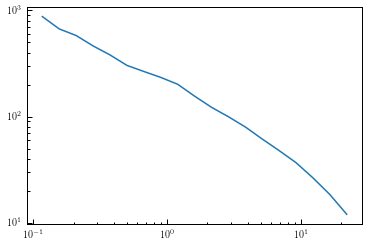

In [48]:
plt.plot(rbin_centers, result)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [49]:
r = [0.385, 0.577, 0.865, 1.299, 1.945, 2.921, 4.381, 6.572, 9.858, 14.78, 22.18, 33.27]
w = [619.29, 390.51, 242.17, 153.87, 106.83, 84.18, 60.42, 43.19, 30.70, 19.83, 12.66, 7.22]
err = [27.20, 18.80, 9.51, 5.60, 4.60, 3.17, 2.30, 1.76, 1.69, 1.36, 0.85, 0.87]

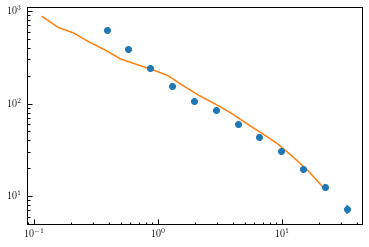

In [50]:
plt.figure()
plt.errorbar(r, w, yerr=err, fmt='o')
plt.plot(rbin_centers, result)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
def project_3d_shape(a3d, b3d, c3d, q3d, s3d):
    """
    This function projects 3D ellipsoidal shapes onto a 2D ellipse and returns
    the 2 cartesian components of the ellipticity.


    See Piras2017:1707.06559 section 3.1
    and Joachimi2013:1203.6833
    """

    s = np.stack([a3d, b3d, c3d])
    w = np.stack([np.ones_like(q3d), q3d, s3d])

    k = np.sum(s[:,:,0:2]*np.expand_dims(s[:,:,2], axis=-1) / np.expand_dims(w[:,:]**2, axis=-1), axis=0)
    a2 =np.sum(s[:,:,2]**2/w[:,:]**2, axis=0)
    Winv = np.sum(np.einsum('ijk,ijl->ijkl', s[:,:,0:2], s[:,:,0:2]) /
               np.expand_dims(np.expand_dims(w[:,:]**2,-1),-1), axis=0) - np.einsum('ij,ik->ijk', k,k)/np.expand_dims(np.expand_dims(a2,-1),-1)
    W = np.linalg.inv(Winv)
    d = np.sqrt(np.linalg.det(W))
    e1 = (W[:,0,0] - W[:,1,1])/( W[:,0,0] + W[:,1,1] + 2*d)
    e2 = 2 * W[:,0,1]/( W[:,0,0] + W[:,1,1] + 2*d)
    return e1, e2